In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

from time import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cross_validation import cross_val_score, train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [5]:
# load data
data = pd.read_csv('data.csv')
total_actions = dict(data.action_type.value_counts())
# TODO: tune this parameter
threshold = 100
# TODO: check if it's needed
data['type'] = data.apply(lambda row: row['action_type'] if total_actions[row['action_type']] >= threshold \
                          else row['combined_shot_type'], axis=1)
data['time_remaining'] = data.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)

# TODO: tune this parameter
threshold = 3
# TODO: find out why he cant hit @ 14 secs to go
anomaly = 14
data['last_moment'] = data.apply(lambda row: row['time_remaining'] < threshold or row['time_remaining'] == anomaly, axis=1)
data['away'] = data.matchup.str.contains('@')
data['season'] = data.apply(lambda row: int(row['season'].split('-')[0]), axis=1)
data['month'] = data.apply(lambda row: int(row['game_date'].split('-')[1]), axis=1)

# remove outliers
data['shot_distance'] = data.apply(lambda row: 28 if row['shot_distance'] > 28 else row['shot_distance'], axis=1)

features = [
    'shot_distance',
    'last_moment',
    'away',
]
binarize = [
    #'type',
    'period',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'opponent',
    'season',
    #'shot_type',
    'action_type',
    'combined_shot_type'
]

dummie_counter = {}
for feature in binarize:
    dummie_counter[feature] = len(data[feature].unique())
    
data = pd.concat([data[binarize], pd.get_dummies(data, columns=binarize)], axis=1)
for col in data.columns.tolist():
    for feature in binarize:
        if col.startswith(feature) and col != feature:
            features.append(col)
data.head()

,period,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,season,action_type,combined_shot_type,game_event_id,game_id,...,action_type_Turnaround Fadeaway shot,action_type_Turnaround Finger Roll Shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot
0,1,Right Side(R),Mid-Range,16-24 ft.,POR,2000,Jump Shot,Jump Shot,10,20000012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,Left Side(L),Mid-Range,8-16 ft.,POR,2000,Jump Shot,Jump Shot,12,20000012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,Left Side Center(LC),Mid-Range,16-24 ft.,POR,2000,Jump Shot,Jump Shot,35,20000012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,Right Side Center(RC),Mid-Range,16-24 ft.,POR,2000,Jump Shot,Jump Shot,43,20000012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,Center(C),Restricted Area,Less Than 8 ft.,POR,2000,Driving Dunk Shot,Dunk,155,20000012,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
def get_acc(data, field):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.xlabel(field)
    plt.ylabel('% shots made')
    plt.show()
    
def plot_accuracy(data, field, sort=False):
    ct = pd.crosstab(data.shot_made_flag, data[field]).apply(lambda x: x / x.sum(), axis=0)
    temp = list(zip(ct.values[1, :], ct.columns))
    if sort:
        temp.sort()
    new_map = {}
    for index, (acc, old_number) in enumerate(temp):
        new_map[old_number] = index
    ct = pd.crosstab(data.shot_made_flag, data[field].map(new_map)).apply(lambda x: x / x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.plot(x, y)
    plt.title('sorted = ' + str(sort))
    plt.xlabel(field)
    plt.ylabel('% shots made')

def plot(data, field):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plot_accuracy(data, field, sort=False)
    plt.subplot(122)
    plot_accuracy(data, field, sort=True)
    plt.show()

In [6]:
# split into train and test
train = data[~data['shot_made_flag'].isnull()]
test = data[data['shot_made_flag'].isnull()]
print('train size: ' + str(len(train)))
print('test size:  ' + str(len(test)))

train size: 25697
test size:  5000


In [7]:
features = [
    'shot_distance', 
    'last_moment', 
    'away'
] 
binarize = [
    'period', 
    'shot_zone_area',
    'shot_zone_basic', 
    'shot_zone_range', 
    'opponent', 
    'season', 
    'action_type', 
    'combined_shot_type' 
] 

for col in data.columns.tolist():
    for feature in binarize:
        if col.startswith(feature) and col != feature:
            features.append(col)
            
# prepare data for estimators
target = 'shot_made_flag'
X_test = test[features]
X_train = train[features]
y_train = train[target]
print(X_train.shape)
print(y_train.shape)

(25697, 144)
(25697,)


In [6]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds, metrics=['logloss'], show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Test params
    X_train, X_valid, y_train, y_valid = train_test_split(dtrain[predictors], dtrain[target], test_size=0.2)
    alg.fit(X_train, y_train, eval_metric='logloss')
    y_pred = alg.predict_proba(X_valid)[:,1]
    
    result = log_loss(y_valid, y_pred)
    print(result)
    return result

In [7]:
params = {
    'base_score': 0.5, 
    'colsample_bylevel': 1,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 1,
    'n_estimators': 1000,
    'nthread': -1,
    'objective': 'binary:logistic',
    'seed': 27,
    'silent': True,
    'subsample': 0.8
}

clf = xgb.XGBClassifier()

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


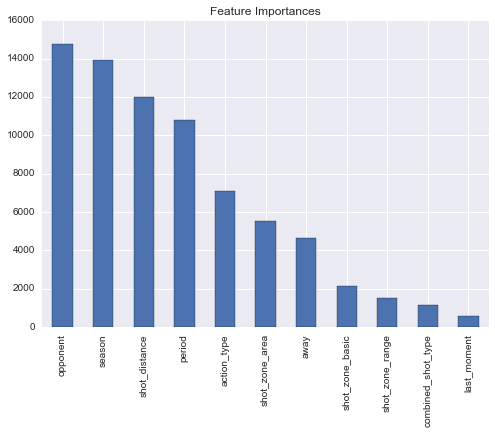

In [8]:
# fit, predict and generate submission file
clf = xgb.XGBClassifier()
clf.set_params(**params)
clf.fit(X_train, y_train)
test.shot_made_flag = [i[1] for i in clf.predict_proba(X_test)]
test[['shot_id', 'shot_made_flag']].to_csv('sub1.csv', index=False)

# display feature importances
# TODO: prettify this code
feature_importances = clf.booster().get_fscore()
to_pop = []
for dummie in binarize:
    feature_importances[dummie] = 0
for feature in feature_importances:
    for dummie in binarize:
        if feature.startswith(dummie) and feature not in binarize:
            feature_importances[dummie] += feature_importances[feature]
            to_pop.append(feature)
for feature in to_pop:
    feature_importances.pop(feature, None)
#for dummie in binarize:
#    feature_importances[dummie] /= dummie_counter[dummie]
feat_imp = pd.Series(feature_importances).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

In [23]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time

mainLearner = ExtraTreesClassifier(n_estimators=500, max_depth=5, 
                                   min_samples_leaf=100, max_features=100, 
                                   criterion='entropy', bootstrap=False, 
                                   n_jobs=-1, random_state=42)

mainLearner = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, 
                                 colsample_bytree=0.8, learning_rate=0.01, 
                                 max_depth=8, min_child_weight=1, n_estimators=1000, 
                                 nthread=-1, objective='binary:logistic', seed=27,
                                 silent=False, subsample=0.8)

mainLearner = RandomForestClassifier(n_estimators=300, n_jobs=-1)
featuresDB = X_train[features].reset_index(drop=True)
labelsDB = y_train.reset_index(drop=True)
                        
crossValidationIterator = cross_validation.StratifiedKFold(labelsDB, n_folds=5, shuffle=True, random_state=42)

startTime = time.time()
trainAccuracy = []; validAccuracy = [];
trainLogLosses = []; validLogLosses = []
for trainInds, validInds in crossValidationIterator:
    # split to train and valid sets
    X_train_CV = featuresDB.ix[trainInds,:]
    y_train_CV = labelsDB.iloc[trainInds]
    X_valid_CV = featuresDB.ix[validInds,:]
    y_valid_CV = labelsDB.iloc[validInds]
    
    # train learner
    mainLearner.fit(X_train_CV, y_train_CV)
    
    # make predictions
    y_train_hat_mainLearner = mainLearner.predict_proba(X_train_CV)[:,1]
    y_valid_hat_mainLearner = mainLearner.predict_proba(X_valid_CV)[:,1]

    # store results
    trainAccuracy.append(accuracy(y_train_CV, y_train_hat_mainLearner > 0.5))
    validAccuracy.append(accuracy(y_valid_CV, y_valid_hat_mainLearner > 0.5))
    trainLogLosses.append(log_loss(y_train_CV, y_train_hat_mainLearner))
    validLogLosses.append(log_loss(y_valid_CV, y_valid_hat_mainLearner))

print("-----------------------------------------------------")
print("total (train,valid) Accuracy = (%.5f,%.5f). took %.2f minutes" % (np.mean(trainAccuracy),np.mean(validAccuracy), (time.time()-startTime)/60))
print("total (train,valid) Log Loss = (%.5f,%.5f). took %.2f minutes" % (np.mean(trainLogLosses),np.mean(validLogLosses), (time.time()-startTime)/60))
print("-----------------------------------------------------")

-----------------------------------------------------
total (train,valid) Log Loss = (0.59862,0.60547). took 0.32 minutes
-----------------------------------------------------


In [42]:
[3, 5, 6] / 5

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [36]:
counter = 0
for index, value in zip(res[0][1], res[0][0]):
    counter += 1
    print(index, value)
    if counter == 10:
        break

5 0.420378
15 0.349579
20 0.751427
24 0.343663
25 0.280992
26 0.741917
35 0.921959
37 0.325641
47 0.376277
49 0.699394


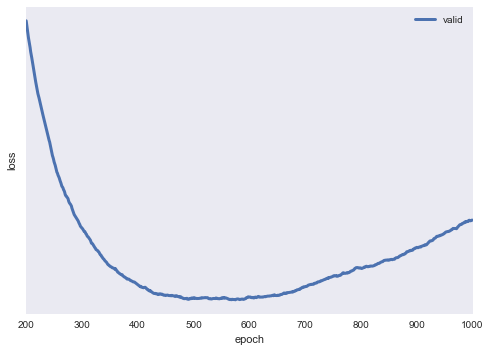

In [106]:
valid_loss = cv_res['test-logloss-mean'][200:]
train_loss = cv_res['train-logloss-mean'][200:]
#plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
lb = min(valid_loss.min(), valid_loss.min())
ub = max(valid_loss.max(), valid_loss.max())
delta = (ub - lb) / 20
plt.ylim(lb - delta, ub + delta)
plt.yscale("log")
plt.show()

[ 0.42037845  0.3495791   0.75142735 ...,  0.31653431  0.17588918
  0.31469959]
[    5    15    20 ..., 25673 25684 25695]
